In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

In [9]:
start_run(config_file=Path("Nitrate LSTM.yml"), gpu=-1)

2025-02-01 16:51:47,762: Logging to C:\Users\Hydro\runs\development_run_0102_165147\output.log initialized.
2025-02-01 16:51:47,765: ### Folder structure created at C:\Users\Hydro\runs\development_run_0102_165147
2025-02-01 16:51:47,768: ### Run configurations for development_run
2025-02-01 16:51:47,769: experiment_name: development_run
2025-02-01 16:51:47,771: run_dir: C:\Users\Hydro\runs\development_run_0102_165147
2025-02-01 16:51:47,773: train_basin_file: NitrateConcentration.txt
2025-02-01 16:51:47,774: validation_basin_file: NitrateConcentration.txt
2025-02-01 16:51:47,775: test_basin_file: NitrateConcentration.txt
2025-02-01 16:51:47,777: train_start_date: 2018-01-01 00:00:00
2025-02-01 16:51:47,778: train_end_date: 2020-01-01 00:00:00
2025-02-01 16:51:47,781: validation_start_date: 2021-01-02 00:00:00
2025-02-01 16:51:47,782: validation_end_date: 2022-01-01 00:00:00
2025-02-01 16:51:47,785: test_start_date: 2018-01-01 00:00:00
2025-02-01 16:51:47,787: test_end_date: 2023-11-27 

NotImplementedError: No dataset class implemented for dataset Alabama_gwl

### Evaluate run on test set
The run directory that needs to be specified for evaluation is printed in the output log above. Since the folder name is created dynamically (including the date and time of the start of the run) you will need to change the `run_dir` argument according to your local directory name. By default, it will use the same device as during the training process.

In [71]:
run_dir = Path("runs/test_run_1808_040905")
eval_run(run_dir=run_dir, period="test")

2023-08-18 12:37:40,553: Using the model weights from runs\test_run_1808_040905\model_epoch050.pt
# Evaluation: 100%|██████████| 4/4 [00:16<00:00,  4.24s/it]
2023-08-18 12:37:57,547: Stored results at runs\test_run_1808_040905\test\model_epoch050\test_results.p


### Load and inspect model predictions
Next, we load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [72]:
with open(run_dir / "test" / "model_epoch050" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['11111111', '11111113', '11111114', '11111120'])

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

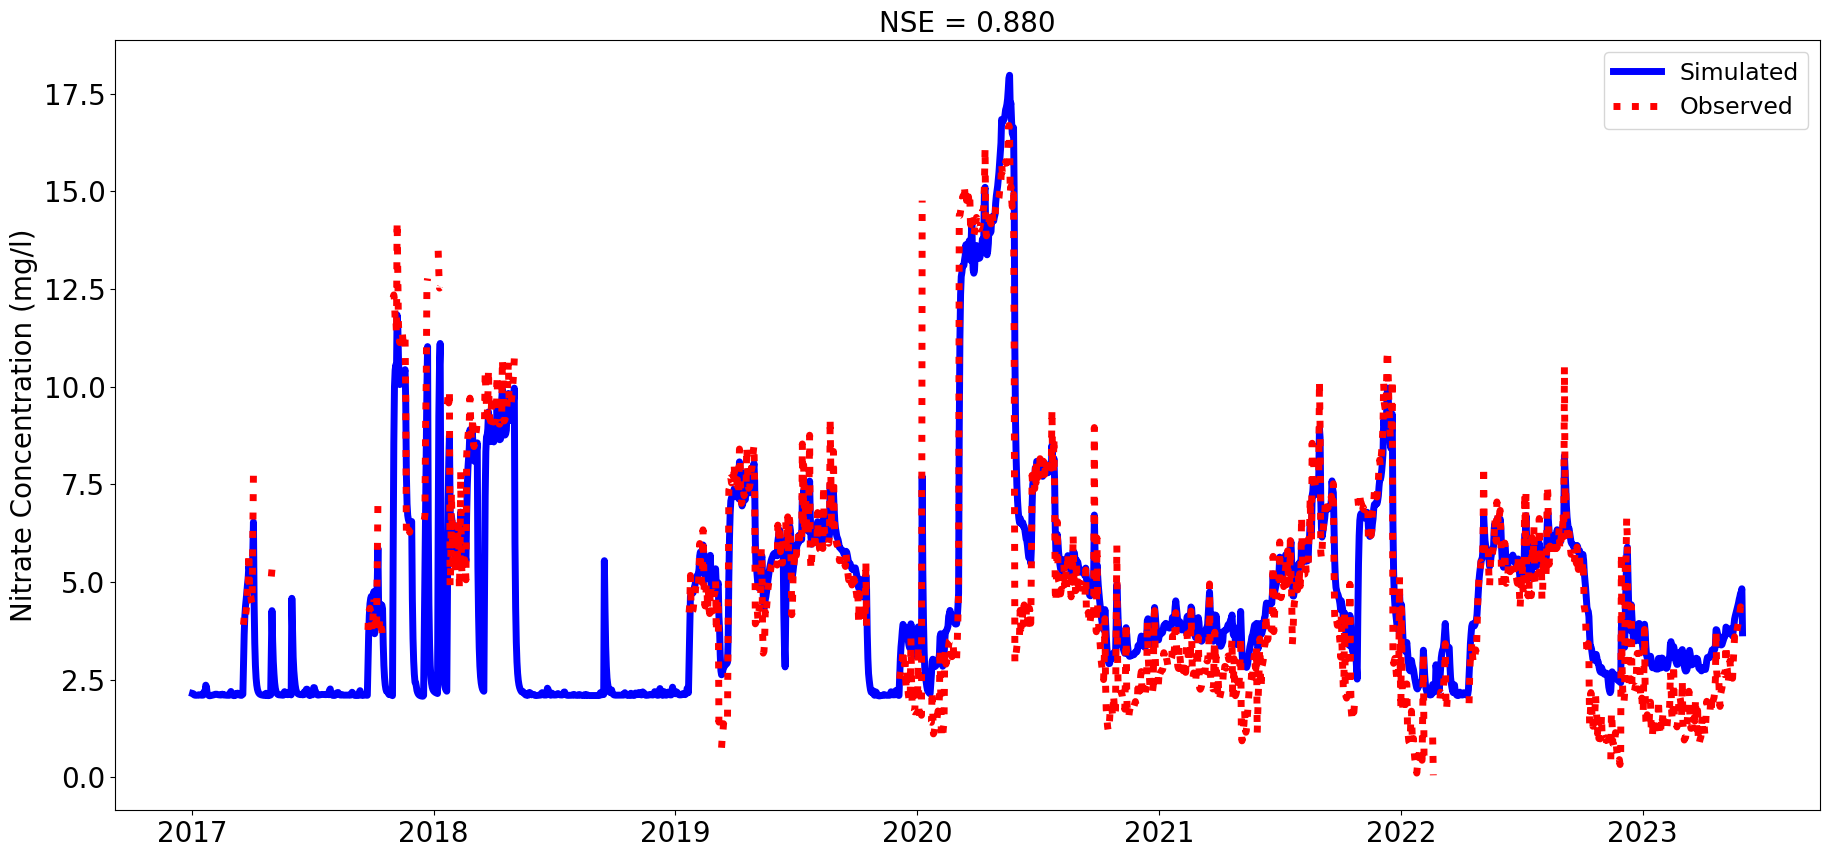

In [78]:
# extract observations and simulations
Nsim = results['11111120']['1D']['xr']['NObs_sim']
Nobs = results['11111120']['1D']['xr']['NObs_obs']

fig, ax = plt.subplots(figsize=(22,10))
ax.plot(qsim['date'], Nsim, **{'color': 'blue', 'ls': 'solid', 'linewidth':5,}, label='Simulated')
ax.plot(qobs['date'], Nobs, **{'color': 'red', 'ls': 'dotted', 'linewidth':5,}, label='Observed')

ax.set_ylim(ax.get_ylim())
ax.set_ylabel("Nitrate Concentration (mg/l)", fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax.set_title(f"NSE = {results['11111120']['1D']['NSE']:.3f}", fontdict={'fontsize': 20, 'fontweight': 'medium'})
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
ax.legend(loc='upper right',fontsize= 17,)